# makemore MLP
If we take more context, more characters, it quickly get's unmanageable. e.g. 4 chars = 27^3 ~ 19200 possibilities. This lesson will cover implementing a Neural net architecture and use embeddings to allow us to consider larger block input sizes.

## setup

In [2]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt

In [3]:
words = open("../names.txt").read().splitlines()

In [4]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
# build the vocabulary of characters and mappings to and from ints
chars = sorted(list(set(''.join(words))) + ['.'])
itos = {idx: ch for idx, ch in enumerate(chars)}
stoi = {v:k for k, v in itos.items()}

In [5]:
def build_dataset(words, block_size=3):
    # build the full dataset
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

## implementing the model

In [6]:
# build the dataset
block_size = 3
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(f"{''.join(itos[i] for i in context)} --> {itos[ix]}")
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
# tagent: create embedding matrix. We are embedding 27 characters in a 2D embedding
C = torch.randn((27,2))
C.dtype

torch.float32

In [104]:
one_hot_method = F.one_hot(torch.tensor(5), num_classes=27).float() @ C # must have same datatype, one_hot default is log
index_directly = C[5] 
torch.equal(one_hot_method, index_directly)

True

In [105]:
C[5]

tensor([1.0599, 0.4453])

In [106]:
# index using lists
C[[5,6,7]]

tensor([[ 1.0599,  0.4453],
        [-0.7089, -0.5231],
        [-0.7756, -0.7479]])

In [107]:
# can index multiple times and get result in multiple
C[torch.tensor([5,6,7,7,7])]

tensor([[ 1.0599,  0.4453],
        [-0.7089, -0.5231],
        [-0.7756, -0.7479],
        [-0.7756, -0.7479],
        [-0.7756, -0.7479]])

In [108]:
C.shape

torch.Size([27, 2])

In [110]:
C[X].shape # gets embedding vector for each X

torch.Size([32, 3, 2])

In [113]:
# integer is 1
X[13,2]

tensor(1)

In [116]:
# check that the integer at that location of C is the same
C[X][13,2], C[1]

(tensor([-0.6016,  1.6488]), tensor([-0.6016,  1.6488]))

In [115]:
C[1]

tensor([-0.6016,  1.6488])

In [176]:
##########################
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [177]:
# setup first layer
W1 = torch.rand((6,100))
b1 = torch.rand(100)

In [137]:
# tangent: different way to use torch and torch internals
# want to matmul emb @ W1 but they are different sizes: (32,3,2) @ (6,100). 
# need to transform the emb to do this:
first_char_embed = emb[:,0,:]
second_char_embed = emb[:,1,:]
third_char_embed = emb[:,2,:]

# we want to concat across dim 1
torch.cat((first_char_embed,second_char_embed, third_char_embed), dim=1).shape

torch.Size([32, 6])

In [138]:
# above works, but we'd need to change this code if we use a bigger block_size, instead can use unbind:
# unbind will return a tuple of all slices along a given dimension
torch.unbind(emb, 1)
torch.unbind(emb,1)[0].shape # 3 slices in tuple with shape 32, 3

torch.Size([32, 2])

In [165]:
torch.cat(torch.unbind(emb, 1), dim=1).shape # but this inefficient as a whole new tensor is created for this op, uses more memory

torch.Size([32, 6])

In [141]:
# a better way:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [142]:
a.shape

torch.Size([18])

In [159]:
a.view(2,9), a.view(3,3, 2), a.view(9,2), a.view(-1,9) # -1 means whatever is left

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [ 9, 10, 11, 12, 13, 14, 15, 16, 17]]),
 tensor([[[ 0,  1],
          [ 2,  3],
          [ 4,  5]],
 
         [[ 6,  7],
          [ 8,  9],
          [10, 11]],
 
         [[12, 13],
          [14, 15],
          [16, 17]]]),
 tensor([[ 0,  1],
         [ 2,  3],
         [ 4,  5],
         [ 6,  7],
         [ 8,  9],
         [10, 11],
         [12, 13],
         [14, 15],
         [16, 17]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [ 9, 10, 11, 12, 13, 14, 15, 16, 17]]))

In [149]:
a.storage() #physical storage 

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [157]:
torch.cat(torch.unbind(emb, 1), dim=1) == emb.view(32,6)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [158]:
###########################################
emb.view(32,6) @ W1 + b1


tensor([[ 2.9032,  4.1361,  4.5650,  ...,  1.9633,  2.6685,  4.3327],
        [ 2.5082,  3.9130,  4.3207,  ...,  1.9953,  2.3136,  4.0329],
        [ 0.7555,  2.4680,  3.0508,  ...,  2.0188,  0.9817,  2.4596],
        ...,
        [-0.8331, -1.2928, -0.7480,  ...,  0.3800,  1.0624,  0.5667],
        [-0.9798, -0.5661, -1.9993,  ..., -0.4268, -1.9186, -0.0536],
        [-0.6883,  0.9239,  0.4850,  ...,  1.1965,  0.1382,  1.4256]])

In [205]:
# how to deal with dim 0 being variable for X:
h1 = emb.view(32,6) @ W1 + b1
h2 = emb.view(emb.shape[0],6) @ W1 + b1
h3 = emb.view(-1,6) @ W1 + b1 #  -1 means whatever is left.
torch.equal(h1,h2), torch.equal(h1,h3)

(True, True)

In [206]:
################################## 
# back to the hidden layer:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [207]:
# check bias broadcasting when adding:
b1.shape, (emb.view(-1,6) @ W1).shape
# emb @ w1 32, 100
# b1        1, 100 << start at trailing dim, prepend 1 to the dims of the tensor
# copied the b vertically to all the rows, which is what we want


(torch.Size([100]), torch.Size([32, 100]))

In [208]:
W2 = torch.rand((100,27))
b2 = torch.rand(27)

In [209]:
logits = h @ W2 + b2

In [210]:
logits.shape

torch.Size([32, 27])

In [213]:
counts = logits.exp()

In [214]:
prob = counts / counts.sum(1,keepdims=True)

In [215]:
prob.shape

torch.Size([32, 27])

In [217]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [222]:
loss = -prob[torch.arange(32), Y].log().mean() # neg log liklihood loss

In [10]:
# ------------------------- 
# bring the above together
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [157]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [155]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [156]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32,27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = - prob[torch.arange(32), Y].log().mean()
loss


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [258]:
# tangent: cross_entropy means: 
# - creating the intermediate steps and do them together using fused kernels, 
# - expressions can take a simplier form, similar to forward and backward pass of tanh()
# - cross_entry can be much better numericall behaved i.e dealing wtih higher logits

F.cross_entropy(logits, Y)

tensor(7.3572)

In [271]:
# cross_entropy performed much better numericall behaved. As we are exp() the logits, if the logits are high (100) can get nan, -100 is ok:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [272]:
# you can add offset to this and get the same answer:
logits = torch.tensor([-5, -3, 0, 5]) - 10
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [273]:
# same as: 
logits = torch.tensor([-5, -3, 0, 5]) - 20
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [276]:
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [301]:
for p in parameters:
    p.requires_grad = True

In [308]:
# ----------------------------------------
for _ in range(1000):
    # forward pass
    emb = C[X] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.2525448799133301


In [327]:
# return the max index for each row and compare it to the expected index. 
# so some match but other's dont. e.g index 0, as ... predicts either e,o,a,i or s all are possible, from the training set.
# this means it's not possilbe to get loss to 0, and overfit
logits.max(1),Y

(torch.return_types.max(
 values=tensor([ 43.6240,  64.4105,  58.8915,  68.1924,   0.9242,  43.6240,  17.9316,
          11.4024, -17.6828,  33.6481,  45.3112,   8.1901,  43.6240,  23.4733,
          43.4074, -12.2734,  43.6240,  41.4969,  60.3677,  27.2958,  12.0153,
          25.7188,  35.0194,  61.3420, -11.1273,  43.6240,  55.2428,  36.2484,
          31.1155,  21.6926,  57.4884,  13.5841], grad_fn=<MaxBackward0>),
 indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
          1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0])),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [328]:
# how max works
x = torch.arange(10)
y = x.view(-1,5)
y, y.max(1)

(tensor([[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]),
 torch.return_types.max(
 values=tensor([4, 9]),
 indices=tensor([4, 4])))

In [149]:
# build the full dataset
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [152]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [158]:
# setup 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [159]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [160]:
for p in parameters:
    p.requires_grad = True

In [109]:
for _ in range(100):
    # forward pass
    emb = C[X] # (32000,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32000, 100)
    logits = h @ W2 + b2 # (32000,27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

2.805891513824463
2.8053951263427734
2.8048830032348633
2.804353952407837
2.803807020187378
2.8032419681549072
2.8026585578918457
2.802056312561035
2.801433801651001
2.800790309906006
2.800126075744629
2.799440383911133
2.7987329959869385
2.7980029582977295
2.797250270843506
2.796473264694214
2.7956740856170654
2.7948505878448486
2.7940030097961426
2.7931313514709473
2.7922348976135254
2.7913153171539307
2.790372371673584
2.78940486907959
2.788414239883423
2.787402391433716
2.786367893218994
2.7853126525878906
2.7842371463775635
2.7831432819366455
2.7820324897766113
2.7809038162231445
2.77976131439209
2.7786056995391846
2.7774386405944824
2.776261329650879
2.7750768661499023
2.773885488510132
2.7726902961730957
2.771493434906006
2.7702951431274414
2.7690985202789307
2.7679057121276855
2.7667176723480225
2.765536069869995
2.7643625736236572
2.7631986141204834
2.762044906616211
2.760902166366577
2.7597720623016357
2.7586543560028076
2.75754976272583
2.756458282470703
2.755380868911743
2.

In [352]:
# mini-batch to reduce training time, randomly select a batch from the training set and train on that:
torch.randint(0, X.shape[0], (32,)) # low, high and size (as tuple) 

tensor([119797, 135103,  68519,  78310,   1849,  10334, 175244,  22232,  84835,
        132659,  57062, 195604,  94142, 157832,  64927,  78522,  13348,  31850,
        201084, 144172,  40730,  14861,  38417, 140192,  83381, 157992,  29477,
        129486, 162059,  81486,  70888, 223125])

In [17]:
# why minibatch. minibatch will get an approximate gradient rather than exact and it's better to make many steps using 
# an approx gradient, rather than few steps using a more accurate gradient.
for _ in range(100):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # minibatch of 32 items
    # forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Y[ix]) # use minibatch index to get labelled result

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.9648590087890625
2.6528027057647705
2.8100643157958984
2.866823196411133
2.707019567489624
2.848673105239868
3.189858913421631
2.8352770805358887
2.7900948524475098
3.111520528793335
2.859539031982422
3.046997547149658
3.02547287940979
2.5750844478607178
2.832350254058838
2.7211475372314453
3.0934629440307617
3.118736505508423
2.8435776233673096
2.912137508392334
3.017094850540161
2.841599464416504
3.002427101135254
2.844202756881714
2.8834824562072754
3.145188331604004
2.7380101680755615
2.755811929702759
2.7141408920288086
2.876512050628662
2.6551740169525146
3.136817693710327
2.709643840789795
2.808337450027466
3.1058692932128906
2.8435585498809814
2.694821357727051
2.602365732192993
2.595930337905884
2.8852570056915283
2.8886642456054688
2.5396482944488525
2.806668281555176
2.8390884399414062
2.9100406169891357
3.0885636806488037
2.7862789630889893
2.788360595703125
3.2058510780334473
2.909269332885742
3.024956226348877
2.8851728439331055
2.802968740463257
2.913724660873413
2.850

In [20]:
# loss for the full training set
emb  = C[X] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.7607, grad_fn=<NllLossBackward0>)

In [161]:
# learning rates, checking rate
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [163]:
# find the lower and upper bounds, a search range, where loss does not decrease anymore
# we want to investigate where the learning rate is between: 0.001 and 1, outside of this the loss either doesn't decrease or increases.

LEARNING_RATE = 1
for _ in range(100):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # minibatch of 32 items
    # forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Y[ix]) # use minibatch index to get labelled result
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -LEARNING_RATE * p.grad 
print(loss.item())

5.457016944885254


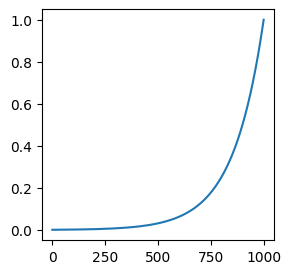

In [164]:
# to step linearly through the expoents from 10^-3 =0.0001 to 10^0 = 1
lre = torch.linspace(-3,0, 1000)
lrs = 10**lre
plt.figure(figsize=(3,3))
plt.plot(lrs);

# we want an array with these values 
# we will use this to train the model over 1000 steps with loss at first very small and increases during training as the model's loss decreases. 


In [180]:
# learning rates investigation
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad = True

# learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [181]:
lri = []
lossi = []

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # minibatch of 32 items
    
    # forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Y[ix]) # use minibatch index to get labelled result
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad  # learning rate increases exp() on every back/forwared pass, starting very low

    # track stats
    lri.append(lre[i]) # the expoentent of the learning rate
    lossi.append(loss.item())


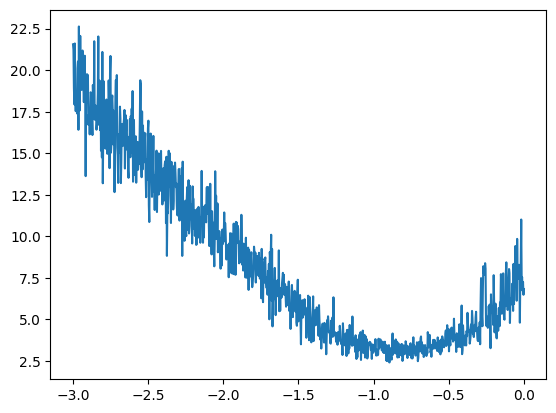

In [182]:
# from this plot we can sort of see the learning rate decreasing to 
plt.plot(lri, lossi);

---
### Train using calculated learning rate
Train the model using best learning rate from above and reduce the learning rate for later passes



In [18]:
def build_dataset(words, block_size=3):
    # build the full dataset
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

In [13]:
# setup 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [16]:
for i in range(180_001):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # minibatch of 32 items
    
    # forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Y[ix]) # use minibatch index to get labelled result
    # print(loss.item())

        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 80000 else 0.01
    
    # report loss
    if i % 10000 == 0:
        print(f"{i:8}|{lr:4}|{loss.item():.4f}")
    # update
    for p in parameters:
        p.data += -lr * p.grad  # learning rate increases exp() on every back/forwared pass, starting very low
# print(loss.item())

       0| 0.1|22.2129
   10000| 0.1|2.4078
   20000| 0.1|2.5332
   30000| 0.1|2.6365
   40000| 0.1|2.0304
   50000| 0.1|2.3038
   60000| 0.1|2.6774
   70000| 0.1|2.3720
   80000|0.01|2.4413
   90000|0.01|2.4039
  100000|0.01|2.2133
  110000|0.01|2.1845
  120000|0.01|1.9422
  130000|0.01|2.1329
  140000|0.01|2.1042
  150000|0.01|2.0946
  160000|0.01|2.3513
  170000|0.01|2.5833
  180000|0.01|2.7741


In [17]:
# calculate loss on the full model
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item() # 2.267

2.267183303833008

### Splitting the dataset into training, dev/validation and test sets 

The problem with above is that the model can overfit your dataset. This means the loss will go down to a really low level, nearly 0, memorising dataset completely and result in giving you the exact same words as your training set. And when you evaulate the loss on a new dataset, the loss will be very high. To avoid this we split the datasets into three splits:
- training (80%) - used to train model's parameters
- dev/validation (10%) - used to tune hyperparameters, during dev, and covers hidden layer, strength of regularisation, embedding dimension size, etc
- test (10) - used sparingly to evaluate the performance of the model, only used a few times and we want to avoid training on this to avoid overfitting on this

In [6]:
# split dataset
import random; random.seed(42); random.shuffle(words) # randomly shuffle works

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
# Xtr, Ytr = build_dataset(words[:n1])
# Xdev, Ydev = build_dataset(words[n1:n2])
# Xte, Yte = build_dataset(words[n2:])
X, Y = build_dataset(words)
n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0)
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)

torch.Size([228146, 3]) torch.Size([228146])


In [7]:
Xtr.shape, Xdev.shape, Xts.shape

(torch.Size([182516, 3]), torch.Size([22815, 3]), torch.Size([22815, 3]))

In [46]:
# check
182516 + 22815 + 22815 == 228146

True

In [52]:
# setup 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [56]:
# train using training set only
for i in range(30001):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # minibatch of 32 items
    
    # forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix]) # use minibatch index to get labelled result
    # print(loss.item())

        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # lr = 0.1 if i < 80000 else 0.01
    lr = 0.01
    
    # report loss
    if i % 10000 == 0:
        print(f"{i:8}|{lr:4}|{loss.item():.4f}")
    # update
    for p in parameters:
        p.data += -lr * p.grad  
print(loss.item())

       0|0.01|2.7465
   10000|0.01|2.3776
   20000|0.01|2.3491
   30000|0.01|2.3520
2.351999044418335


In [67]:
# calculate loss on the dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item() # 2.295

2.2951161861419678

In [68]:
# calculate loss on the training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item() # 2.280

# the dev and training loss is roughly equal 2.29 vs 2.28 which means the model is not overfitting.
# It's not memorising the data. means network is very tiny, not powerful enough for memorisation and so can scale up the size of the network

2.2800023555755615

In [72]:
# let's increase the size of the nn
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

10281

In [91]:
# train using training set only and keep track of loss and steps
lri, lossi, stepi = [],[],[]

for i in range(30001):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # minibatch of 32 items
    
    # forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix]) # use minibatch index to get labelled result
    # print(loss.item())

        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # lr = 0.1 if i < 80000 else 0.01
    lr = 0.01
    
    # report loss
    if i % 10000 == 0:
        print(f"{i:8}|{lr:4}|{loss.item():.4f}")
    # update
    for p in parameters:
        p.data += -lr * p.grad  

    stepi.append(i)
    lossi.append(loss.item())
# print(loss.item())

       0|0.01|2.0438
   10000|0.01|2.2236
   20000|0.01|1.9122
   30000|0.01|2.2546


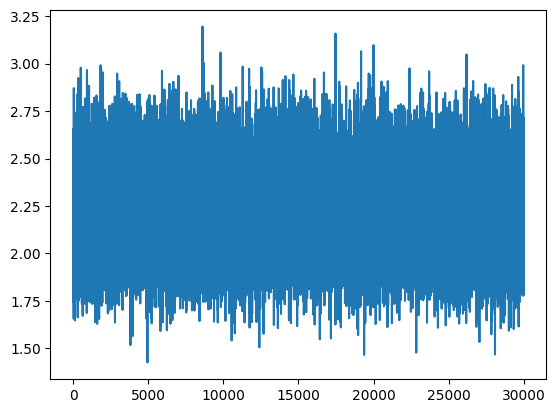

In [92]:
plt.plot(stepi, lossi); # flucutations and noise relate to the small size of the minibatches

In [93]:
# loss on dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item() # 2.295

2.2383651733398438

In [94]:
# loss on test set
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item() # 2.280

2.221623420715332

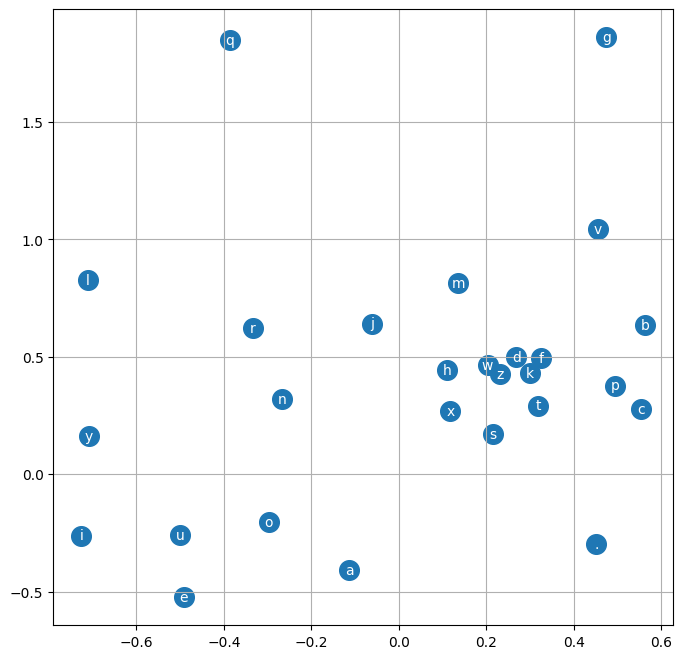

In [100]:
# visualise the embeddings - showing the clusters vowels together, q and g not related, dkfwz related 
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor");

In [8]:
# scale up the embeddings and reduce the hidden layer to 200
# let's increase the size of the nn
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

# track loss
lri, lossi, stepi = [],[],[]

In [9]:
# train using training set only and keep track of loss and steps

for i in range(200001):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # minibatch of 32 items
    
    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # lr = 0.1 if i < 80000 else 0.01
    lr = 0.1 if i < 100_000 else 0.01
    
    # report loss
    if i % 10000 == 0:
        print(f"{i:8}|{lr:4}|{loss.item():.4f}")
    # update
    for p in parameters:
        p.data += -lr * p.grad  

    stepi.append(i)
    lossi.append(loss.log10().item())
# print(loss.item())

       0| 0.1|25.4951
   10000| 0.1|2.6810
   20000| 0.1|2.5024
   30000| 0.1|2.6916
   40000| 0.1|1.9188
   50000| 0.1|1.9770
   60000| 0.1|1.8740
   70000| 0.1|2.2253
   80000| 0.1|2.2983
   90000| 0.1|2.1508
  100000|0.01|1.9470
  110000|0.01|1.9528
  120000|0.01|2.2688
  130000|0.01|2.0416
  140000|0.01|1.8446
  150000|0.01|1.9945
  160000|0.01|2.1926
  170000|0.01|2.0000
  180000|0.01|1.9780
  190000|0.01|2.2802
  200000|0.01|2.0930


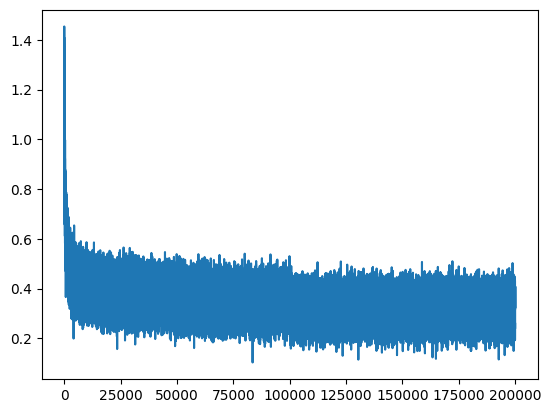

In [10]:
# plotting the log loss
plt.plot(stepi, lossi);

In [69]:
# loss on dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item() # 2.295

2.159353256225586

In [70]:
# loss on test set
emb = C[Xts]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yts)
loss.item() # 2.280

2.1503145694732666

In [ ]:
# in prod you'd create lots of experiements with all the hyperparameters and then check the all the hyperparamerters which make the dev loss good. 
# training and dev set loss is slowly seperating and the nn is good enough, the number of parameters is big enough that the model is overfitting. 
# after you have evaluated the hyperparameters and got the best dev loss, you run it a single time on the test dataset and that is the final loss.

# hyperparmaters
# - size of the embedding 
# - size of the hidden layer
# - block size for the context
# - learning rate decay
# - batch size (32)

# 2.17 test loss is target

## Sample from the model

In [68]:
g = torch.Generator().manual_seed(2147483647+10)
block_size = 3

for _ in range(20):
    # reset
    context = [0] * block_size
    word = []

    # generate word
    while True: 
        emb = C[context]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) # emb.view(1, -1) - just one row input
        logits = h @ W2 + b2
        counts = logits.exp() # 1 character output : 1,27
        p = counts / counts.sum(1, keepdim=True) # same as just counts.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # context = torch.cat((context[1:], torch.tensor([idx])))
        context = context[1:] + [ix]
        if itos[ix] == '.':
            break
        word.append(itos[ix])
    print (''.join(word))


mona
kmyah
seel
ndyn
alerethan
endraeg
adelyn
elin
shy
jen
edelieananar
kayziqhotelin
shur
rixairiel
kindreelynn
nophorius
kyndi
jamell
eli
kayjahsalyan


In [50]:
C[[0,0,0]]

tensor([[ 1.6678,  0.7611,  0.3539, -0.9374,  0.8805, -0.2013, -1.8563,  0.9030,
          0.4532,  1.1826],
        [ 1.6678,  0.7611,  0.3539, -0.9374,  0.8805, -0.2013, -1.8563,  0.9030,
          0.4532,  1.1826],
        [ 1.6678,  0.7611,  0.3539, -0.9374,  0.8805, -0.2013, -1.8563,  0.9030,
          0.4532,  1.1826]], grad_fn=<IndexBackward0>)

In [44]:
C[torch.tensor([0,0,0])]

tensor([[ 1.6678,  0.7611,  0.3539, -0.9374,  0.8805, -0.2013, -1.8563,  0.9030,
          0.4532,  1.1826],
        [ 1.6678,  0.7611,  0.3539, -0.9374,  0.8805, -0.2013, -1.8563,  0.9030,
          0.4532,  1.1826],
        [ 1.6678,  0.7611,  0.3539, -0.9374,  0.8805, -0.2013, -1.8563,  0.9030,
          0.4532,  1.1826]], grad_fn=<IndexBackward0>)

In [63]:
emb = C[[0,0,0]]

In [67]:
emb.shape, emb.view(-1,30).shape, emb.view(1,-1).shape

(torch.Size([3, 10]), torch.Size([1, 30]), torch.Size([1, 30]))